In [1]:
!pip -q install pytorch_lightning

     |████████████████████████████████| 584 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 409 kB 42.7 MB/s 
     |████████████████████████████████| 136 kB 48.8 MB/s 
     |████████████████████████████████| 1.1 MB 38.7 MB/s 
     |████████████████████████████████| 271 kB 49.4 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 144 kB 6.3 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/projects/autify/data.zip .
!unzip -q data.zip

In [4]:
import torch, torchvision
from torchvision import transforms
import cv2, os, glob, time, datetime, json
from PIL import Image
import numpy as np
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import sklearn

#### Config

In [13]:
class Config():
    experiment_id = 'experiment_1'
    base_dir = '/content/drive/MyDrive/projects/autify'
    data_dir = f'./data'
    exp_dir = f'{base_dir}/experiemnts/{experiment_id}'
    os.makedirs(exp_dir, exist_ok=True)

    label_format = {"checked": 0, "unchecked": 1, "other": 2}
    augmentations = True
    seed = 0
    splits = {"train": 0.8, "val": 0.1, "test": 0.1}
    freeze_until = "layer4"
    epochs = 20
    models = ["resnet50", "resnet18"]
    optimizers = ["Adam", "RMSprop"]
    batch_sizes = [4, 8]
    lr = [1e-3, 1e-4]

#### Utils

In [6]:
def combine(terms, combinations, accum=[]):
    last = (len(terms) == 1)
    n = len(terms[0])
    for i in range(n):
        item = accum + [terms[0][i]]
        if last:
            combinations.append(item)
        else:
            combine(terms[1:], combinations, item)

#### Loading data

#### Transforms

In [7]:
from torchvision import transforms

training_trasnformations = transforms.Compose(
    [transforms.Resize((64,128)),
    #  transforms.TrivialAugmentWide(),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),                    
     transforms.ToTensor(),                     
     transforms.Normalize(                      
     mean=[0.485, 0.456, 0.406],                
     std=[0.229, 0.224, 0.225])]
)

testing_trasnformations = transforms.Compose(
    [transforms.Resize((64,128)),                    
     transforms.ToTensor(),                     
     transforms.Normalize(                      
     mean=[0.485, 0.456, 0.406],                
     std=[0.229, 0.224, 0.225])]
)  

#### DataGen

In [8]:
import torch

class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, data, transforms = None):
        self.data = data
        self.transforms = transforms
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transforms:
            image = self.transforms(image)
        return image, torch.tensor(label, dtype=torch.long)

torch.Size([3, 64, 128]) tensor(0)


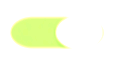

In [ ]:
from google.colab.patches import cv2_imshow
for x, y in DataGenerator(data=test, transforms=training_trasnformations):
    print(x.size(), y)
    x = np.transpose(np.array(x),(1,2,0))
    cv2_imshow(x*255)
    break

#### Model

In [9]:
import torch, torchvision
import pytorch_lightning as pl
import torchmetrics

class Model(pl.LightningModule):
    def __init__(self, model_name="resnet18", num_classes=3, lr=1e-3, optimizer_name="Adam", freeze_until=None, weights=None):
        super().__init__()
        self.model = getattr(torchvision.models, model_name)(pretrained=True)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)
        if freeze_until is not None:
            for l in self.model.named_children():
                if l[0] == freeze_until:
                  break
                for params in l[1].parameters():
                    params.requires_grad = False
        if weights:
            weights=torch.tensor(weights, dtype=torch.float)
        self.ce_loss = torch.nn.CrossEntropyLoss(weight=weights, 
                                                  label_smoothing=0.1)
        self.train_accuracy = torchmetrics.F1Score()
        self.valid_accuracy = torchmetrics.F1Score()
        self.epoch = 0
        self.lr = lr
        self.optimizer_name = optimizer_name

    def forward(self, batch):
        x = self.model(batch)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.ce_loss(y_hat, y)
        
        accuracy = self.train_accuracy(torch.nn.functional.softmax(y_hat, dim=-1), y)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", accuracy, on_epoch=True, prog_bar=True, on_step=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.ce_loss(y_hat, y)
        
        accuracy = self.valid_accuracy(torch.nn.functional.softmax(y_hat, dim=-1), y)
        
        self.log("valid_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("valid_accuracy", accuracy, on_epoch=True, prog_bar=True, on_step=True)
    
    def validation_epoch_end(self, outputs):
        accuracy = self.valid_accuracy.compute()
        self.log('valid_accuracy_epoch', accuracy)
        self.valid_accuracy.reset()
        # print(f'{self.epoch}: Validation accuracy: ', accuracy.cpu().numpy())

    def training_epoch_end(self, outputs):
        accuracy = self.train_accuracy.compute()
        self.log('train_accuracy_epoch', accuracy)
        self.train_accuracy.reset()
        # print(f'{self.epoch}: Training accuracy: ', accuracy.cpu().numpy())
        self.epoch += 1  

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.optimizer_name)(self.parameters(), lr=self.lr)
        return optimizer

#### Training

In [ ]:
import torch
import os, time, datetime, json
from PIL import Image
import numpy as np
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def main():
    os.makedirs(Config.exp_dir, exist_ok=True)
    data = {}
    for dir in os.listdir(Config.data_dir):
        if(not os.path.isdir(f'{Config.data_dir}/{dir}')):
            continue 
        data[dir] = []
        for image_file in os.listdir(f'{Config.data_dir}/{dir}'):
            data[dir].append([Image.open(f'{Config.data_dir}/{dir}/{image_file}').convert('RGB'), 
                              Config.label_format[dir]])
        np.random.seed(Config.seed)
        np.random.shuffle(data[dir])

    train, val, test = [], [], []
    for d in data:
        print(f'Total {len(data[d])} files in {d}')
        print(f'Training files in {d}: {int(Config.splits["train"]*len(data[d]))}')
        print(f'Training files in {d}: {int(Config.splits["val"]*len(data[d]))}')
        print(f'Training files in {d}: {int(Config.splits["test"]*len(data[d]))}')
        
        train.extend(data[d][:int(Config.splits["train"]*len(data[d]))])
        val.extend(data[d][int(Config.splits["train"]*len(data[d])): int((Config.splits["train"]+Config.splits["val"])*len(data[d]))])
        test.extend(data[d][int((Config.splits["train"]+Config.splits["val"])*len(data[d])):])

    print(len(train), len(val), len(test))

    counts = np.array([0]*len(Config.label_format))
    for i in train:
        counts[i[1]] +=1
    WEIGHTS = (np.sum(counts)-counts) / np.sum(counts)
    WEIGHTS 

    hyperparam_combinations = []
    combine([Config.models]+[Config.optimizers]+[Config.lr]+[Config.batch_sizes], hyperparam_combinations)

    logger = {}
    times, acc = [],[]
    for model_name, optimizer, lr, batch_size in hyperparam_combinations:
        print(f'RUN: {model_name}, {optimizer}, {lr}, {batch_size}')

        classifier = Model(model_name=model_name,
                          num_classes=len(Config.label_format), 
                          optimizer_name=optimizer,
                          lr=lr,
                          freeze_until="layer4"
                          )
        trainer = pl.Trainer(accelerator="gpu", 
                        devices=1,
                        default_root_dir=Config.exp_dir,
                        deterministic=False, 
                        max_epochs=Config.epochs,
                        gradient_clip_val=1.0,
                        auto_lr_find=True,
                        callbacks=ModelCheckpoint(save_top_k=1,
                                                  monitor="valid_accuracy",
                                                  mode="max",
                                                  dirpath=Config.exp_dir,
                                                  filename=f"{model_name}-{lr}-{optimizer}-{batch_size}",
                                                  verbose=False,
                                                  save_weights_only=True)
                        )
        start = time.time()
        trainer.fit(classifier, 
                    torch.utils.data.DataLoader(DataGenerator(data=train, transforms=training_trasnformations), 
                                                batch_size=batch_size, 
                                                num_workers=1,
                                                shuffle = True), 
                    torch.utils.data.DataLoader(DataGenerator(data=val, transforms=testing_trasnformations), 
                                                batch_size=2, 
                                                num_workers=1, 
                                                shuffle=False))
        train_time = time.time() - start

        classifier.load_state_dict(torch.load(f'{Config.exp_dir}/{model_name}-{lr}-{optimizer}-{batch_size}.ckpt')["state_dict"])
        classifier.eval()
        Y, Yhat = [], []
        start = time.time()
        for x,y in DataGenerator(data=test, transforms=testing_trasnformations):
            y_hat = torch.argmax(classifier.forward(torch.unsqueeze(x, 0))[0])
            Y.append(y.detach().cpu().numpy())
            Yhat.append(y_hat.detach().cpu().numpy())
        
        infer_time = time.time() - start
        accuracy = accuracy_score(Y, Yhat)
        f1 = f1_score(Y, Yhat, average='macro')
        precision = precision_score(Y, Yhat, average='macro')
        reacall = recall_score(Y, Yhat, average='macro')

        times.append(train_time)
        acc.append(accuracy)
        logger[f"run: {model_name}-{lr}-{optimizer}-{batch_size}"] = {
                                                    "train time": str(datetime.timedelta(seconds=train_time)),
                                                    "infer time": str(datetime.timedelta(seconds=infer_time)),
                                                    "Test Accuracy": accuracy,
                                                    "Test F1": f1,
                                                    "Test Precision": precision,
                                                    "Test Recall": reacall}

    with open(f'{Config.exp_dir}/logging.json', 'w') as fp:
        json.dump(logger, fp, indent=4)
    
    plt.scatter(times, acc)
    plt.xlabel('time in s')
    plt.ylabel('Test Accuracy')
    plt.savefig(f'{Config.exp_dir}/time vs acc.png')
    print('Done!')

if __name__ == "__main__":
    main()

Total 138 files in other
Training files in other: 110
Training files in other: 13
Training files in other: 13
Total 222 files in checked
Training files in checked: 177
Training files in checked: 22
Training files in checked: 22
Total 155 files in unchecked
Training files in unchecked: 124
Training files in unchecked: 15
Training files in unchecked: 15
411 51 53
RUN: resnet50, Adam, 0.001, 4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/drive/MyDrive/projects/autify/experiemnts/experiment_1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 23.5 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet50, Adam, 0.001, 8


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 23.5 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet50, Adam, 0.0001, 4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 23.5 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet50, Adam, 0.0001, 8


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 23.5 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet50, RMSprop, 0.001, 4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 23.5 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet50, RMSprop, 0.001, 8


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 23.5 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet50, RMSprop, 0.0001, 4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 23.5 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet50, RMSprop, 0.0001, 8


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 23.5 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet18, Adam, 0.001, 4


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 11.2 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet18, Adam, 0.001, 8


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 11.2 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet18, Adam, 0.0001, 4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 11.2 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RUN: resnet18, Adam, 0.0001, 8


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/projects/autify/experiemnts/experiment_1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 11.2 M
1 | ce_loss        | CrossEntropyLoss | 0     
2 | train_accuracy | F1Score          | 0     
3 | valid_accuracy | F1Score          | 0     
----------------------------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '{exp_dir}/lightning_logs' 